In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn import model_selection
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.metrics import silhouette_score
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from tslearn.metrics import cdist_dtw


/home/constance/Lang/python/anaconda3/envs/MLBD_Calcularis_Sectumsempra/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Generate data

In [2]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

In [13]:
# Initialize the random number generator
np.random.seed(24)

# Define the parameters
a = [0.8,0.7,0.8]
b = [0.3,0.2,0.3]
lambda_ = [0.1,0.2,0.5]
scale_param = 60
nb_students = 300

# Generate dummy student data
proba_dataset = pd.DataFrame({'user_id': [], 'attempt': [], 'correct_predictions': [], 'group':[]})
max_attempt = (np.rint(np.random.exponential(scale_param, nb_students))).astype(
    int)  # We saw that the number of attempts per student is exponentially distributed

#remove students with too small number of attempts
min_attempt = 200

for i in range(len(max_attempt)):
    if max_attempt[i] > min_attempt:
        user_id = np.repeat(i, max_attempt[i])
        attempt = np.arange(max_attempt[i])
        #e = np.random.randn(max_attempt[i]) * (
         #           np.random.randn() * 0.1 + 0.1)  # Generate some noise with a different variance for each student
        group = random.randint(0, 1) #Choose parameter index
        correct_predictions = exp_model(attempt, a[group], b[group], lambda_[group])  # Generate the probability of success for each attempt

        proba_dataset = pd.concat([proba_dataset, pd.DataFrame(
            {'user_id': user_id, 'attempt': attempt, 'correct_predictions': correct_predictions, 'group' : np.repeat(group, len(user_id))})], ignore_index=True)

proba_dataset

,user_id,attempt,correct_predictions,group
0,2.0,0.0,0.500000,1.0
1,2.0,1.0,0.536254,1.0
2,2.0,2.0,0.565936,1.0
3,2.0,3.0,0.590238,1.0
4,2.0,4.0,0.610134,1.0
...,...,...,...,...
5090,287.0,225.0,0.800000,0.0
5091,287.0,226.0,0.800000,0.0
5092,287.0,227.0,0.800000,0.0
5093,287.0,228.0,0.800000,0.0


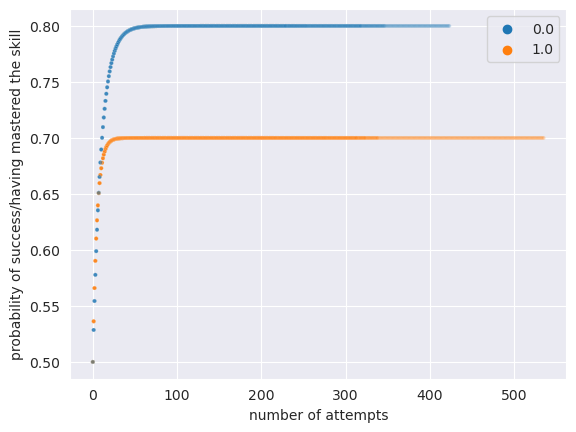

In [14]:
sns.scatterplot(data=proba_dataset, x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8)
plt.xlabel('number of attempts')
plt.ylabel('probability of success/having mastered the skill')
plt.legend()
plt.show()

In [15]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    display(df.user_id.nunique())
    df_array = (df.groupby('user_id').agg({'correct_predictions': lambda x: list(x)}))
    display(df_array)

    #data = pd.DataFrame(df_array["correct_predictions"].values.tolist()).values
    return df_array

data = get_time_series(proba_dataset)
data.shape

#data = data['correct_predictions'].values.tolist()

18

,correct_predictions
user_id,
2.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
6.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
24.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
49.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
52.0,"[0.5, 0.5285487745892121, 0.5543807740766056, ..."
75.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
79.0,"[0.49999999999999994, 0.5362538493844036, 0.56..."
160.0,"[0.5, 0.5285487745892121, 0.5543807740766056, ..."
206.0,"[0.5, 0.5285487745892121, 0.5543807740766056, ..."


(18, 1)

# Clustering with Dynamic Time Warping

In [16]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity
    :return: adjacency matrix
    """

    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')

    return adjacency

def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues

    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)  #Compute the unnormalized graph laplacian
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state, n_init=10)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]

    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary:
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1
    plt.show()

def get_heuristics_spectral(W, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering

    :param W: np array of adjacency matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    eigengap_list = []

    df_labels = pd.DataFrame()

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)
        y_pred = kmeans.labels_
        df_labels[str(k)] = y_pred

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }

    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
        return df_labels
    else:
        return df_labels, metric_dictionary

def get_distance_matrix(X, metric='euclidean', window=2):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :param window: int for DTW
    :return: np.array with distance matrix
    """
    #norms = np.linalg.norm(X, axis=1)
    #data_normalized = X / norms[:, np.newaxis]

    data_normalized = X['correct_predictions'].apply(lambda x: [i/np.linalg.norm(x) for i in x]).values.tolist()

    if metric == 'dtw':
        distance_matrix = cdist_dtw(data_normalized,
                                    global_constraint='sakoe_chiba',
                                    sakoe_chiba_radius=window)
    else:
        distance_vector = distance.pdist(data_normalized, metric)
        distance_matrix = distance.squareform(distance_vector)
    return distance_matrix

def get_affinity_matrix(D, gamma=1):
    """
    calculates affinity matrix from distance matrix
    :param D: np.array distance matrix
    :param gamma: float coefficient for Gaussian Kernel
    :return:
    """
    S = np.exp(-gamma * D ** 2)
    return S

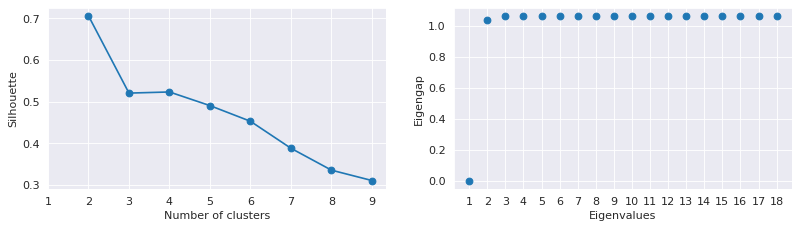

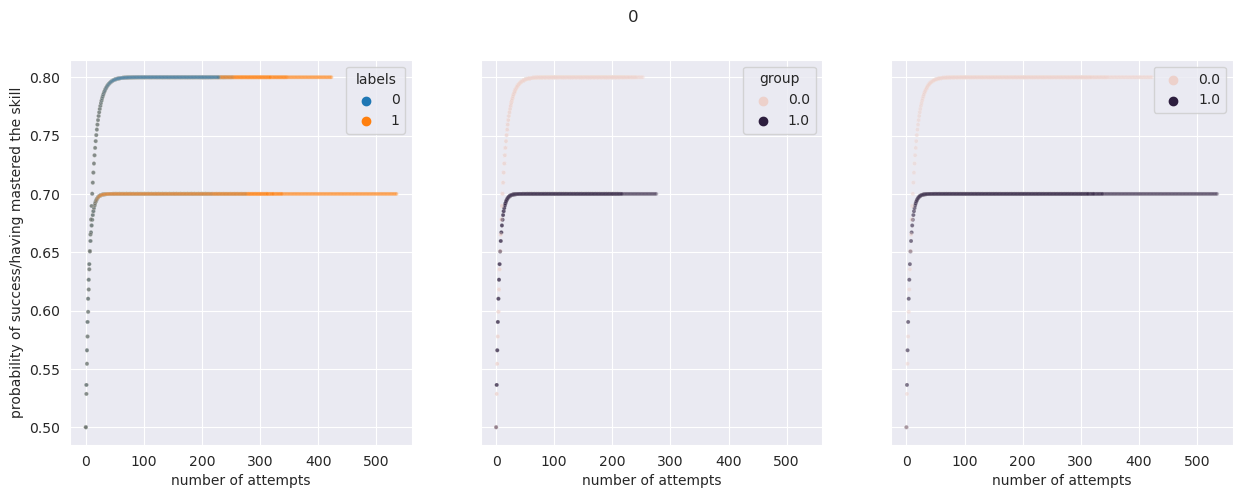

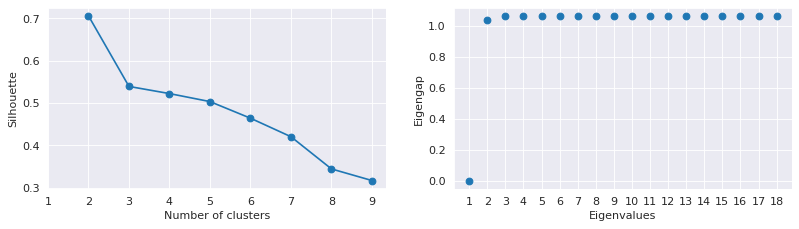

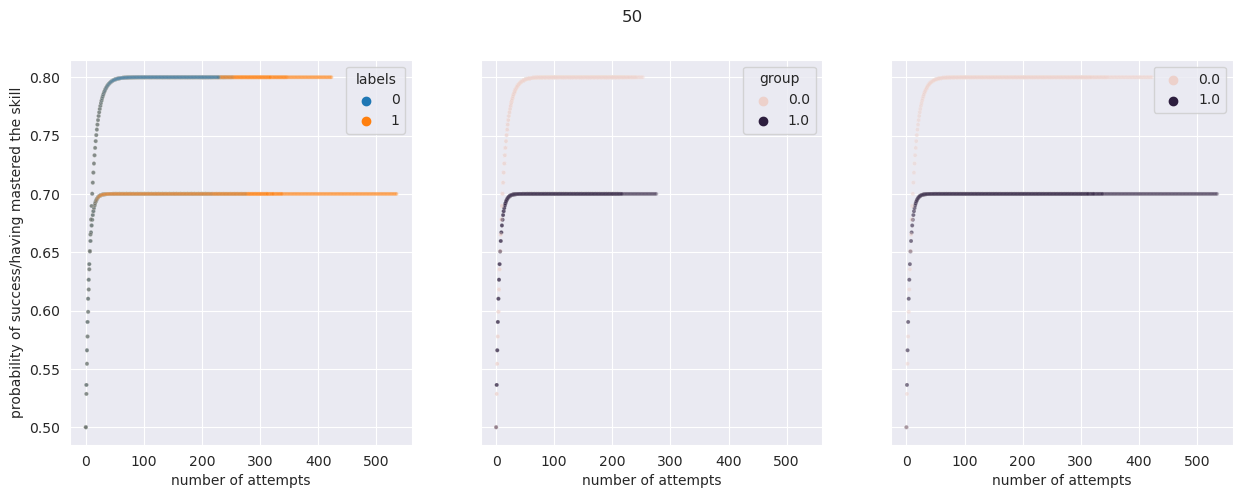

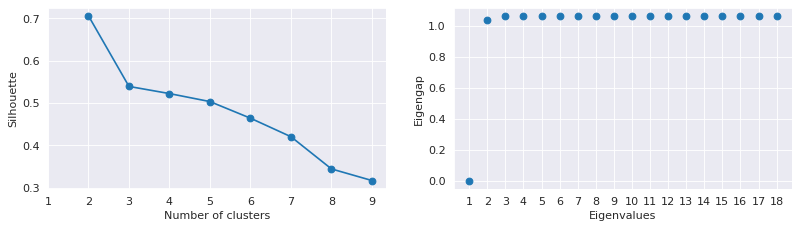

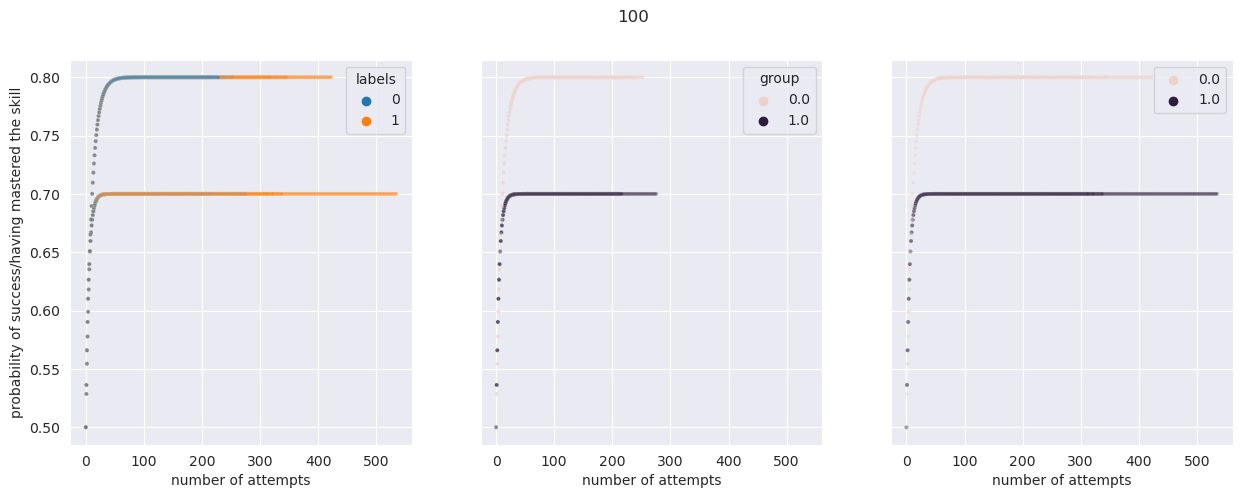

In [19]:
window = [0,50,100]
gamma = [0.01,0.1,1]

for w in window:

    #Clustering
    D = get_distance_matrix(data, metric='dtw', window=w)
    S = get_affinity_matrix(D)
    W = get_adjacency(S)
    n_cluster_list = range(1, 10)

    #Observe ideal number of clusters
    df_labels = get_heuristics_spectral(W, n_cluster_list)
    kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, 2)

    #get labels predictions
    y_pred = kmeans.labels_
    data["labels"]=y_pred
    proba_dataset = proba_dataset.merge(data['labels'], on='user_id')

    #Vizualize
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True,sharey=True)

    sns.scatterplot(data=proba_dataset, x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='labels', alpha=0.2, s=8, ax=axs[0])
    sns.scatterplot(data=proba_dataset[proba_dataset['labels']==0], x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8, ax=axs[1])
    sns.scatterplot(data=proba_dataset[proba_dataset['labels']==1], x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8, ax=axs[2])
    for i in range(3):
        axs[i].set_xlabel('number of attempts')
        axs[i].set_ylabel('probability of success/having mastered the skill')
    fig.suptitle(w)
    plt.legend()
    plt.show()

    proba_dataset = proba_dataset.drop('labels', axis=1)

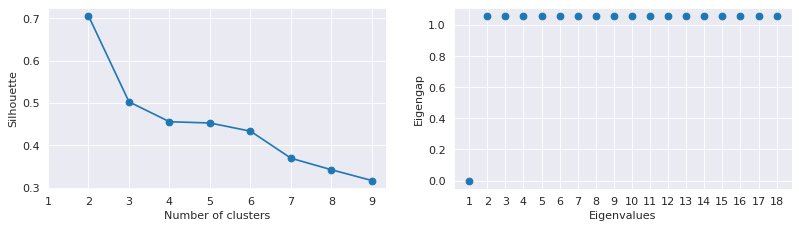

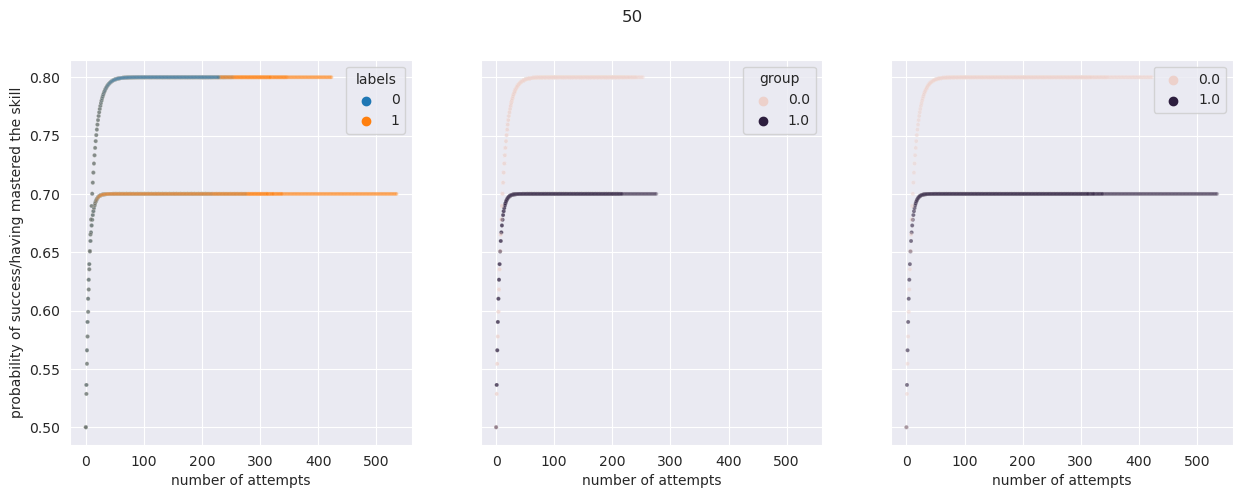

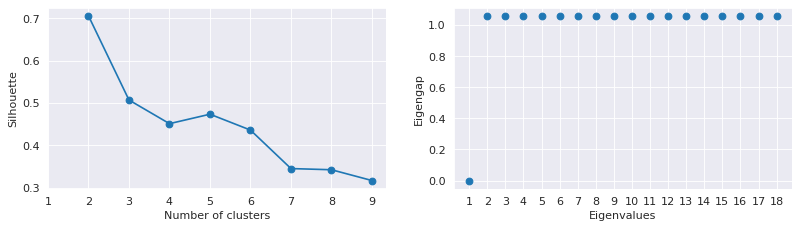

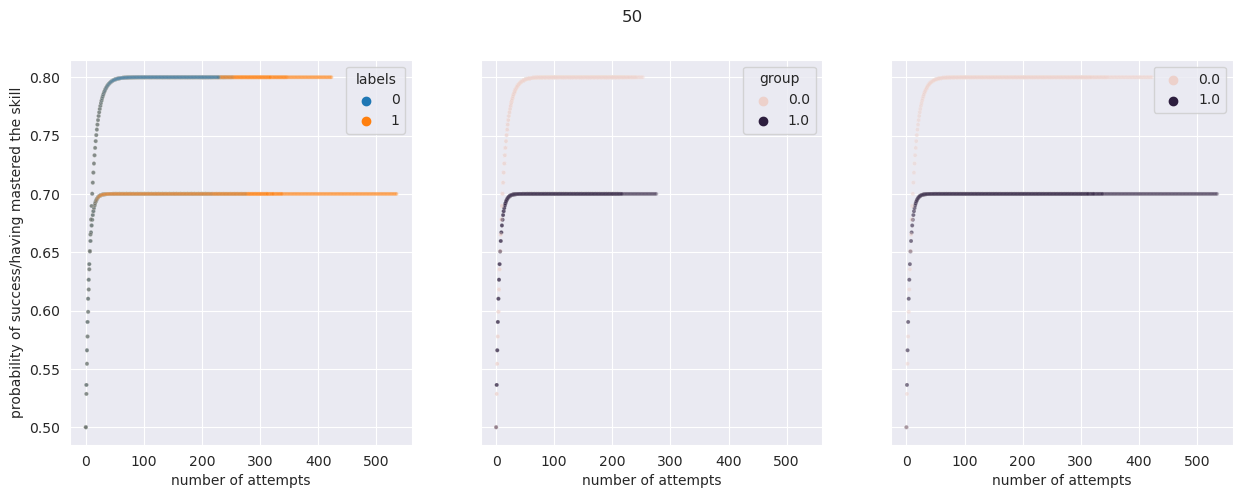

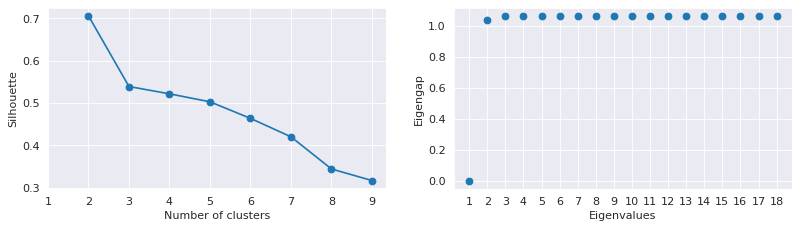

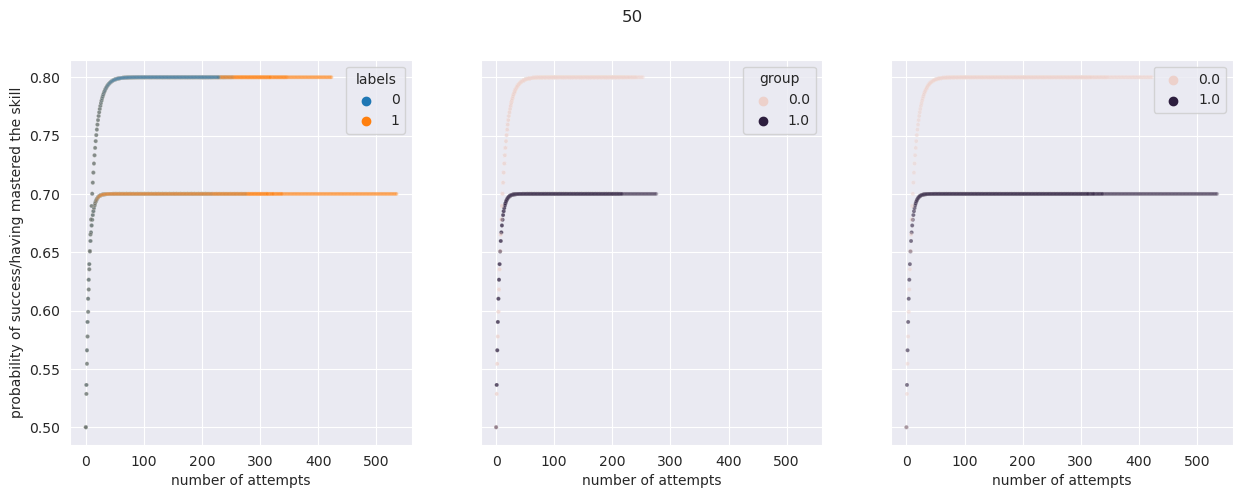

In [18]:
window = [0,10,50]
gamma = [0.01,0.1,1]

for g in gamma:

    #Clustering
    D = get_distance_matrix(data, metric='dtw', window=10)
    S = get_affinity_matrix(D, gamma=g)
    W = get_adjacency(S)
    n_cluster_list = range(1, 10)

    #Observe ideal number of clusters
    df_labels = get_heuristics_spectral(W, n_cluster_list)
    kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, 2)

    #get labels predictions
    y_pred = kmeans.labels_
    data["labels"]=y_pred
    proba_dataset = proba_dataset.merge(data['labels'], on='user_id')

    #Vizualize
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True,sharey=True)

    sns.scatterplot(data=proba_dataset, x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='labels', alpha=0.2, s=8, ax=axs[0])
    sns.scatterplot(data=proba_dataset[proba_dataset['labels']==0], x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8, ax=axs[1])
    sns.scatterplot(data=proba_dataset[proba_dataset['labels']==1], x = proba_dataset.attempt, y = proba_dataset.correct_predictions, hue='group', alpha=0.2, s=8, ax=axs[2])
    for i in range(3):
        axs[i].set_xlabel('number of attempts')
        axs[i].set_ylabel('probability of success/having mastered the skill')
    fig.suptitle(w)
    plt.legend()
    plt.show()

    proba_dataset = proba_dataset.drop('labels', axis=1)